**Load packages:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
#1 Code to read file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#2. Get the file
#make sure you upload all your data files to your Google drive and change share->Advanced->change->anyone with the link can view
downloaded = drive.CreateFile({'id':'1bzX353ZARbSFSgO40bVY5O19nYUUZKzT'}) # replace the id with id of file you want to access
downloaded.GetContentFile('restaurant_reviews-v2-1.xlsx') 

<a name='load_data'></a>

### 1 Extract features for each review

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
# Read .xlsx file into a DataFrame.
df = pd.read_excel('restaurant_reviews-v2-1.xlsx')
df.head(5)

,Restaurant,Review,Real=1/Fake=0,positive=1/negative=0,Author,AWL,ASL,NOW,NVB,NAJ,NPV,NST,CDV,NTP,TPR
0,Tikka Shack,Great food and great atmosphere! The chicken tikka masala and garlic naan tasted as if they had come straight from India itself. Because I was so pleased with the entrée I ended \nup ordering the gulab jamun desert and mango lassi beverage and again I was nothing but pleased! Also the employees and management were all very attentive and they made\nsure we had everything we needed from beginning to end. The manager Matt personally came around even to check on our experience!,0,1,Qui L.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tikka Shack,"I had heard good things about Tikka Shak so I decided to go ahead and give the restaurant a try. The atmosphere was not what I was expecting. Walking through the front door it\nfelt as if it was a trying way too hard to be modern rather than Indian. The cashier took our orders and was polite, however, when I asked her to make my food mild she must not\nhave been listening. The food was brought out after waiting for 15 - 20 minutes and it was so spicy I could barely take the flavor of my paneer tikka masala. Overall I was very \ndisappointed with my experience.",0,0,Pooja K.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tikka Shack,"I was driving by tikka shack one day and decided to give it a try during my lunch break. I am not very familiar with Indian food and don't have the option too try it as I was born in \nLubbock. However, I am glad that I did because now I know that it is not for me. The tikka kabobs were way to spicy. I don't know if it were a mistake or all there food is that spicy. \nThe sides of the rice dish they gave me were also burned on the edges making it hard to even want to eat. I will not be coming to their establishment again.",0,0,Pooja K.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Tikka Shack,"Tikka Shack had the most modern and up-to-date atmosphere of any restaurant period. This was my first time trying Indian food and I was very please with what I got. They did an \nAMAZING job of assimilating Indian and American culture, and the chicken tikka pizza showed just that! I will for sure be returning with friends and family!",0,1,Qui L.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,India Palace\nIndian\nRestaurant,Today is the third time I've come to India Palace Indian Restaurant and I have to say that they have consistently great food. The food tastes like it is straight from India. From the \nfluffy garlic naan to their delicious perfect butter chicken.The service was also so friendly and they constantly were checking on us to make sure that we had everything that we \nneeded. 5 stars!!!! I will definitely be coming back.,0,1,Pooja K.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(260, 15)

In [ ]:
# Make a copy of the dataframe.
df1 = df.copy()

In [ ]:
# Number of sentences

! pip install textstat
import textstat

df1['NST'] = df1['Review'].apply(textstat.sentence_count)

# Textstat is better than sent_tokenize because sent_tokenize makes double puncktuations like "!!" an extra sentence. (row 255 for example)
# df1['NST'] = df1['Review'].apply(sent_tokenize).tolist()
# df1['NST'] = df1['NST'].apply(len)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 105 kB 5.0 MB/s 
     |████████████████████████████████| 2.0 MB 40.2 MB/s 


In [ ]:
# Number of words

df1['NOW'] = df1['Review'].apply(lambda x: len(x.split()))

In [ ]:
# Average word length
df1['AWL'] = df1['Review'].apply(lambda x: np.mean([len(word) for word in x.split()]))

In [ ]:
# Average sententce length
df1['ASL'] = df1['NOW']/df1['NST']

In [ ]:
!python -m spacy download en
!python -m spacy download en_core_web_lg
import spacy
#import en_core_web_lg
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_lg')

2022-11-10 00:25:06.528382: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 3.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2022-11-10 00:25:23.254801: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 17 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
# USE spaCy
# Number of verbs

def tag_verb(review):
  doc = nlp(review)
  counter = 0
  for word in doc:
    if word.pos_ == 'VERB':
      #print(word.text, word.pos_)
      counter += 1
  return counter

df1['NVB'] = df1['Review'].apply(lambda x: tag_verb(x))

In [ ]:
#######USE nltk

# import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# from nltk import word_tokenize, sent_tokenize, pos_tag

# def tag_verb(review):
#   words = nltk.word_tokenize(review)
#   tags = nltk.pos_tag(words)
#   counter = 0
#   for t in tags:
#         if t[1] == 'VB' or t[1] == 'VBG' or t[1] == 'VBD' or t[1] == 'VBN' or t[1] == 'VBP' or t[1] == 'VBZ':
#             print(t[0], t[1])
#             counter += 1
#   return counter

#############Result of this shown as below, "was" "were" are treated as verb as well.#############
# recommend VB
# was VBD       <----
# served VBN
# ordered VBD
# refused VBD
# admit VB
# brought VBD
# were VBD       <----
# refunded VBN
# was VBD        <----

In [ ]:
# Number of adjective

def tag_adj(review):
  doc = nlp(review)
  counter = 0
  for word in doc:
    if word.pos_ == 'ADJ':
      #print(word.text, word.pos_)
      counter += 1
  return counter

  # words = nltk.word_tokenize(review)
  # tags = nltk.pos_tag(words)
  # counter = 0
  # for t in tags:
  #       # print(t[0], t[1])
  #       if t[1] == 'JJ' or t[1] == 'JJR' or t[1] == 'JJS':
  #           counter += 1
  # return counter

df1['NAJ'] = df1['Review'].apply(lambda x: tag_adj(x))

In [ ]:
# Number of passive voice

def tag_pv(review):
  doc = nlp(review)
  # sents = list(doc.sents)
  # print("Number of Sentences = ",len(sents))
  # for sent in doc.sents:
  #     for token in sent:
  #         print(token.dep_,token.tag_, end = " ")
  pv_matcher = Matcher(nlp.vocab)
  passive_rule_pattern = [
      {"DEP": "nsubjpass", "OP": "*"},
      {"DEP": "aux", "OP": "*"},
      {"DEP": "auxpass"},
      {"DEP": "nsubj", "OP": "*"},
      {"TAG": "VBN"},
  ]
  pv_matcher.add('Passive', [passive_rule_pattern])
  pv_matches = pv_matcher(doc)
  counter = len(pv_matches)
  return counter

df1['NPV'] = df1['Review'].apply(lambda x: tag_pv(x))
#df1[df1['NPV']>0]

In [ ]:
# Number of words in vocabulary

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

# Get the bag_of_words
my_additional_stop_words = ["________"]
stopwords = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)
count = CountVectorizer(stop_words=stopwords) 
bag_of_words = count.fit_transform(df1['Review'])

# content = bag_of_words.toarray()
# content.shape
# count.vocabulary_

# Get the number of vocabulary, V
feature_names = count.get_feature_names()
num_vocabulary = len(feature_names)    # V
print(f"The vocabulary contains {num_vocabulary} words.")

The vocabulary contains 1834 words.


In [ ]:
# Number of words with stop_words removal
df1['no_punc'] =  df1['Review'].str.replace('[^\w\s]+', '')  # remove punctuations
df1['no_stopwords'] = df1['no_punc'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
df1['num_of_tokens'] = df1['no_stopwords'].apply(lambda x: len(x.split()))

In [ ]:
# Content diversity ( |V| / # of tokens) (Do not consider punctuation and stop words )
df1['CDV'] = num_vocabulary / df1['num_of_tokens']

In [ ]:
# USE SpellChecker
# Number of typos

! pip install pyspellchecker
from spellchecker import SpellChecker

def check_word_spelling1(review):
    spell = SpellChecker()
    words = review.split()
    words = spell.unknown(words)

    counter = 0
    for word in words: 
      if word != spell.correction: 
          # Manually rule out some words 
          if word == 'entrée' or word == 'kabobs' or word == 'lubbock' or word == 'wasnt' or word == 'didnt' or word == 'isnt' or word == 'hasnt' or word == 'doesnt': 
            continue
          else:
            #print(word, spell.correction(word))
            counter += 1
    return counter

df1['NTP'] = df1['no_punc'].apply(check_word_spelling1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.2 MB/s 


In [ ]:
# USE Textblob
# # Number of typos

# from textblob import Word
# import re
# #from string import punctuation as punct

# def check_word_spelling(review):   
#     words = review.split()
#     words = [word.lower() for word in words]
#     #words = [word.lower().strip(punct) for word in words]
#     #words = [re.sub(r'[^A-Za-z0-9]+', '', word) for word in words]
    
#     counter = 0
#     for word in words: 
#       word = Word(word)
#       result = word.correct()
#       if word != result:     
#           if word == 'tikka' or word == 'shack' or word == 'masala' or word == 'masala':
#             continue
#           else:
#             #print(word, result)
#             counter += 1
#     return counter

# df1['NTP'] = df1['no_punc'].apply(check_word_spelling)

In [ ]:
# Typo ratio

df1['TPR'] = df1['NTP'] / df1['NOW']

In [ ]:
df1.head(2)

,Restaurant,Review,Real=1/Fake=0,positive=1/negative=0,Author,AWL,ASL,NOW,NVB,NAJ,NPV,NST,CDV,NTP,TPR,no_punc,no_stopwords,num_of_tokens
0,Tikka Shack,Great food and great atmosphere! The chicken tikka masala and garlic naan tasted as if they had come straight from India itself. Because I was so pleased with the entrée I ended \nup ordering the gulab jamun desert and mango lassi beverage and again I was nothing but pleased! Also the employees and management were all very attentive and they made\nsure we had everything we needed from beginning to end. The manager Matt personally came around even to check on our experience!,0,1,Qui L.,4.734940,16.600000,83,11,6,0,5,41.681818,2,0.024096,Great food and great atmosphere The chicken tikka masala and garlic naan tasted as if they had come straight from India itself Because I was so pleased with the entrée I ended \nup ordering the gulab jamun desert and mango lassi beverage and again I was nothing but pleased Also the employees and management were all very attentive and they made\nsure we had everything we needed from beginning to end The manager Matt personally came around even to check on our experience,Great food great atmosphere The chicken tikka masala garlic naan tasted come straight India Because I pleased entrée I ended ordering gulab jamun desert mango lassi beverage I pleased Also employees management attentive sure needed beginning end The manager Matt personally came check experience,44
1,Tikka Shack,"I had heard good things about Tikka Shak so I decided to go ahead and give the restaurant a try. The atmosphere was not what I was expecting. Walking through the front door it\nfelt as if it was a trying way too hard to be modern rather than Indian. The cashier took our orders and was polite, however, when I asked her to make my food mild she must not\nhave been listening. The food was brought out after waiting for 15 - 20 minutes and it was so spicy I could barely take the flavor of my paneer tikka masala. Overall I was very \ndisappointed with my experience.",0,0,Pooja K.,4.118182,18.333333,110,15,9,2,6,35.269231,0,0.000000,I had heard good things about Tikka Shak so I decided to go ahead and give the restaurant a try The atmosphere was not what I was expecting Walking through the front door it\nfelt as if it was a trying way too hard to be modern rather than Indian The cashier took our orders and was polite however when I asked her to make my food mild she must not\nhave been listening The food was brought out after waiting for 15 20 minutes and it was so spicy I could barely take the flavor of my paneer tikka masala Overall I was very \ndisappointed with my experience,I heard good things Tikka Shak I decided ahead restaurant try The atmosphere I expecting Walking door felt trying way hard modern Indian The cashier took orders polite I asked make food mild listening The food brought waiting 15 20 minutes spicy I barely flavor paneer tikka masala Overall I disappointed experience,52


In [ ]:
df2 = df1.copy()

In [ ]:
df2.drop(['no_punc', 'no_stopwords', 'num_of_tokens'], axis = 1, inplace = True)

In [ ]:
df2.to_excel(r'Ngo_Yang_review_features.xlsx', index = False)

In [ ]:
df2.head(2)

,Restaurant,Review,Real=1/Fake=0,positive=1/negative=0,Author,AWL,ASL,NOW,NVB,NAJ,NPV,NST,CDV,NTP,TPR
0,Tikka Shack,Great food and great atmosphere! The chicken tikka masala and garlic naan tasted as if they had come straight from India itself. Because I was so pleased with the entrée I ended \nup ordering the gulab jamun desert and mango lassi beverage and again I was nothing but pleased! Also the employees and management were all very attentive and they made\nsure we had everything we needed from beginning to end. The manager Matt personally came around even to check on our experience!,0,1,Qui L.,4.734940,16.600000,83,11,6,0,5,41.681818,2,0.024096
1,Tikka Shack,"I had heard good things about Tikka Shak so I decided to go ahead and give the restaurant a try. The atmosphere was not what I was expecting. Walking through the front door it\nfelt as if it was a trying way too hard to be modern rather than Indian. The cashier took our orders and was polite, however, when I asked her to make my food mild she must not\nhave been listening. The food was brought out after waiting for 15 - 20 minutes and it was so spicy I could barely take the flavor of my paneer tikka masala. Overall I was very \ndisappointed with my experience.",0,0,Pooja K.,4.118182,18.333333,110,15,9,2,6,35.269231,0,0.000000


<a name='model_training'></a>

### 2 Model Training

In [ ]:
from sklearn.preprocessing import MinMaxScaler

df2.drop(columns=['positive=1/negative=0','Restaurant','Review','Author'], axis=1, inplace=True)
df_scaler = MinMaxScaler()
df_scaled = pd.DataFrame(df_scaler.fit_transform(df2), index=df2.index, columns=df2.columns)
df_scaled.head()

,Real=1/Fake=0,AWL,ASL,NOW,NVB,NAJ,NPV,NST,CDV,NTP,TPR
0,0.0,0.500283,0.455422,0.249169,0.224490,0.153846,0.000000,0.173913,0.086613,0.222222,0.104418
1,0.0,0.240882,0.518072,0.338870,0.306122,0.230769,0.285714,0.217391,0.068598,0.000000,0.000000
2,0.0,0.055987,0.433735,0.345515,0.306122,0.128205,0.285714,0.260870,0.070540,0.000000,0.000000
3,0.0,0.469192,0.388554,0.169435,0.142857,0.179487,0.000000,0.130435,0.125647,0.111111,0.073446
4,0.0,0.479251,0.383133,0.215947,0.204082,0.205128,0.000000,0.173913,0.101626,0.111111,0.059361


In [ ]:
df_scaled.shape

(260, 11)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
X = df_scaled.iloc[:,df_scaled.columns != 'Real=1/Fake=0']
Y = df_scaled['Real=1/Fake=0']

# Splitting 60-20-20 and shuffling data
x, X_test, y, y_test = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=4, shuffle=True)
X_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.25, train_size=0.75, random_state=4, shuffle=True)

<a name='Use filter method to select features'></a>

####  Use Filter method to perform feature selection

In [ ]:
X_train.shape

(156, 10)

In [ ]:
# Removing Constant features using VarianceThreshold

from sklearn.feature_selection import VarianceThreshold

constant_filter = VarianceThreshold(threshold=0)

#Fit and transforming on train data
constant_filter.fit_transform(X_train)

#Extracting all constant columns using get support function of our filter
constant_columns = [column for column in X_train.columns
                   if column not in X_train.columns[constant_filter.get_support()]]

#No. of constant columns
print(len(constant_columns))
print(f'{len(constant_columns)} quasi-constant features were found.')


0
0 quasi-constant features were found.


In [ ]:
# Removing Quasi-Constant Features

qcons_filter = VarianceThreshold(threshold=0.01)

#Fitand transforming on train data
data_qcons = qcons_filter.fit_transform(X_train)

#Extracting all Quasi constant columns using get support function of our filter
qcons_columns = [column for column in X_train.columns
                    if column not in X_train.columns[qcons_filter.get_support()]]

#No. of Quasi constant columns
print(len(qcons_columns))
print(f'{len(qcons_columns)} quasi-constant features were found.')

0
0 quasi-constant features were found.


In [ ]:
# feature selection

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def select_features(X_train, y_train, X_test, num):
	# configure to select "num" features
	fs = SelectKBest(score_func=f_classif, k=num)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [ ]:
# Cross validation

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

def cross_validate(num_splits, X, Y, model):

  kf = KFold(n_splits=num_splits, shuffle= True, random_state=0)
  score_list = []

  for train_idx, test_idx in kf.split(X, Y):
    x_train = X.iloc[train_idx]
    y_train = Y.iloc[train_idx]

    x_test = X.iloc[test_idx]
    y_test = Y.iloc[test_idx]

    model.fit(x_train, y_train) #Training the model
    
    #Making Predictions
    y_pred = model.predict(x_test)

    #f1-score
    report = classification_report(y_test, y_pred, output_dict=True)
    score_list.append(report['macro avg']['f1-score'])
    
  return score_list

<a name='Logistic Regression'></a>

####  2.1 Logistic Regression

In [ ]:
# Select K best features, change "num" to get the best results.

x_log, X_test_log, fs_log = select_features(x, y, X_test, 4)  # 80% 20%
X_train_log, x_eval_log, y_train_log, y_eval_log = train_test_split(x_log, y, test_size=0.25, train_size=0.75, random_state=4, shuffle=True) # 60% 20%

# For training: x_train_log, y_train_log
# For validation: x_eval_log, y_eval_log
# For training + validation: x_log, y
# For test: X_test_log, y_test

In [ ]:
feature_log = fs_log.get_support(indices = True)
feature_names_log = df_scaled.columns[feature_log]
print(feature_names_log)

Index(['ASL', 'NVB', 'NPV', 'NST'], dtype='object')


In [ ]:
#Logistic Regression with Linear Features

from sklearn.linear_model import LogisticRegression

# Fitting Logistic Regression to training set
log = LogisticRegression(penalty='none', solver='saga', random_state=0)
log.fit(X_train_log, y_train_log)

# Making predictions
y_train_log_pred = log.predict(X_train_log) #Training set
y_eval_log_pred = log.predict(x_eval_log)   #Validation set

Training Classification Report: Logistic Regression :
               precision    recall  f1-score   support

         0.0       0.66      0.80      0.72        83
         1.0       0.70      0.53      0.60        73

    accuracy                           0.67       156
   macro avg       0.68      0.66      0.66       156
weighted avg       0.68      0.67      0.67       156

Validation Classification Report: Logistic Regression:
               precision    recall  f1-score   support

         0.0       0.59      0.70      0.64        27
         1.0       0.60      0.48      0.53        25

    accuracy                           0.60        52
   macro avg       0.60      0.59      0.59        52
weighted avg       0.60      0.60      0.59        52



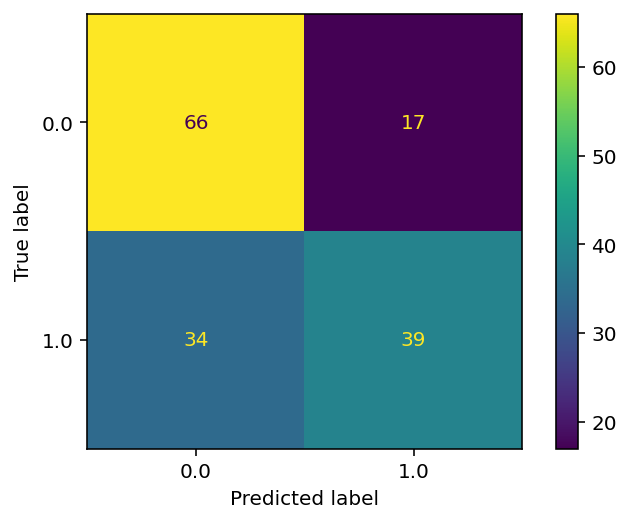

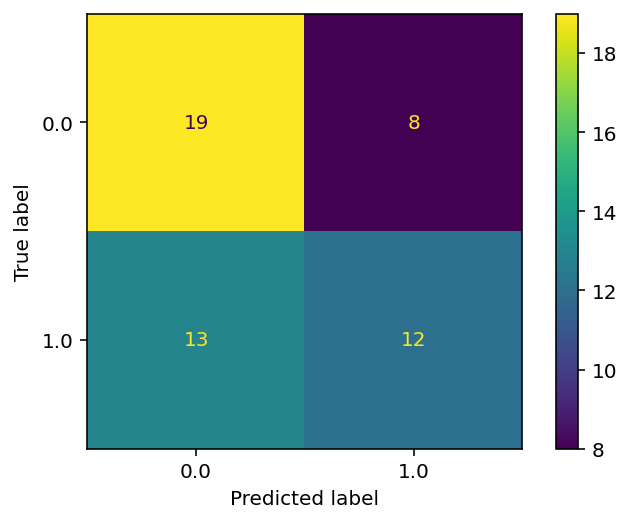

In [ ]:
# Calculating F1-scores & accuracy

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Training Report
log_report_train = classification_report(y_train_log, y_train_log_pred)
print("Training Classification Report: Logistic Regression :\n",log_report_train)

#Getting confusion matrix for Training Data
log_cm_train = confusion_matrix(y_train_log, y_train_log_pred, labels=log.classes_)

disp_train = ConfusionMatrixDisplay(confusion_matrix=log_cm_train, display_labels=log.classes_)
disp_train.plot()

#Validation Report
log_report_validate = classification_report(y_eval_log, y_eval_log_pred)
print("Validation Classification Report: Logistic Regression:\n",log_report_validate)

#Getting confusion matrix for Validation Data
log_cm_validate = confusion_matrix(y_eval_log, y_eval_log_pred, labels=log.classes_)

disp_validate = ConfusionMatrixDisplay(confusion_matrix=log_cm_validate, display_labels=log.classes_)
disp_validate.plot()

In [ ]:
# Train model again using (training and validation) set

# Fitting Logistic Regression to (training + validation) set
log2 = LogisticRegression(penalty='none', solver='saga', random_state=0)
log2.fit(x_log, y)

# Making predictions
y_log_pred = log.predict(x_log) # Training + validation set
y_test_log_pred = log.predict(X_test_log)   # Test set

Training2 Classification Report: Logistic Regression :
               precision    recall  f1-score   support

         0.0       0.64      0.77      0.70       110
         1.0       0.67      0.52      0.59        98

    accuracy                           0.65       208
   macro avg       0.66      0.65      0.64       208
weighted avg       0.66      0.65      0.65       208

Test Classification Report: Logistic Regression:
               precision    recall  f1-score   support

         0.0       0.57      0.80      0.67        20
         1.0       0.83      0.62      0.71        32

    accuracy                           0.69        52
   macro avg       0.70      0.71      0.69        52
weighted avg       0.73      0.69      0.70        52



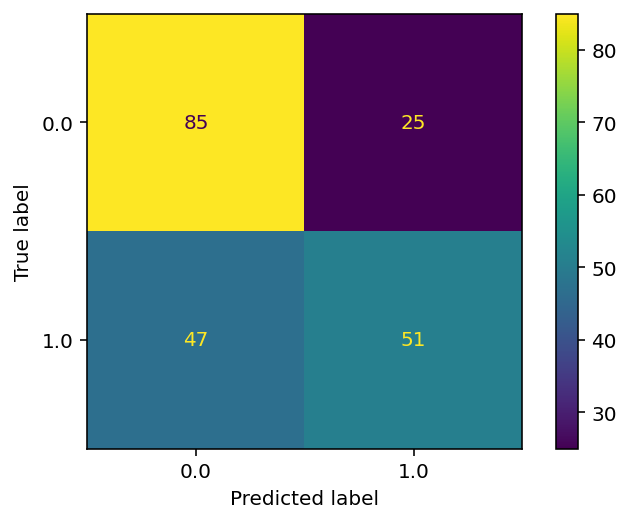

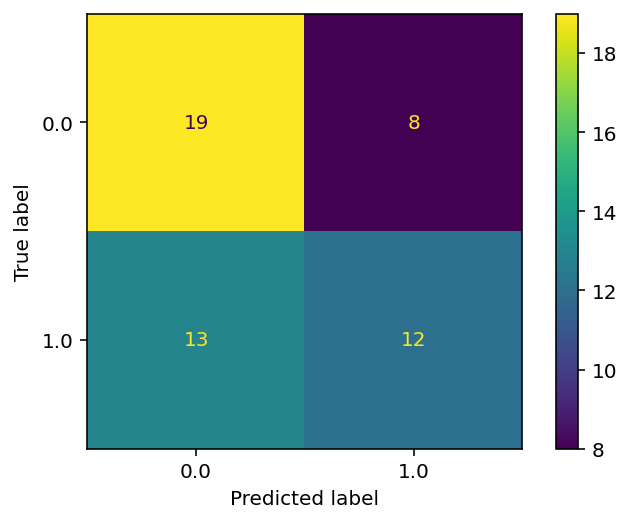

In [ ]:
# Calculating F1-scores & accuracy

#Training + validation Report
log_report_train_val = classification_report(y, y_log_pred)
print("Training2 Classification Report: Logistic Regression :\n",log_report_train_val)

#Getting confusion matrix for Training+validation Data
log_cm_train_val = confusion_matrix(y, y_log_pred, labels=log2.classes_)

disp_train_val = ConfusionMatrixDisplay(confusion_matrix=log_cm_train_val, display_labels=log2.classes_)
disp_train_val.plot()

#Test Report
log_report_test = classification_report(y_test, y_test_log_pred)
print("Test Classification Report: Logistic Regression:\n",log_report_test)

#Getting confusion matrix for Test Data
log_cm_test = confusion_matrix(y_eval_log, y_eval_log_pred, labels=log2.classes_)

disp_test = ConfusionMatrixDisplay(confusion_matrix=log_cm_test, display_labels=log2.classes_)
disp_test.plot()

In [ ]:
# Cross validation to check overfiting/underfitting

x_log_cv = pd.DataFrame(x_log)
log_cv = cross_validate(5, x_log_cv, y, log2)
print("Macro Average F1-score for each fold of Logistic Regression Model: ",log_cv)
print("Average F1-score: ",np.mean(log_cv))

Macro Average F1-score for each fold of Logistic Regression Model:  [0.6636155606407322, 0.6047058823529412, 0.6050156739811912, 0.6076555023923444, 0.6482843137254902]
Average F1-score:  0.6258553866185399


In [ ]:
# Best logistic model to save is log2
import pickle

model_log = log2
pickle.dump(model_log, open('model_log.sav', 'wb'))

<a name='RandomForestRclassifier'></a>

####  2.2 RandomForest Classifier

In [ ]:
# Select K best features, change "num" to get the best results.
x_rf, X_test_rf, fs_rf = select_features(x, y, X_test, 2)  # 80% 20%

In [ ]:
feature_rf = fs_rf.get_support(indices = True)
feature_names_rf = df_scaled.columns[feature_rf]
print(feature_names_rf)

Index(['NVB', 'NPV'], dtype='object')


In [ ]:
#Use GridSearch to fine tune model

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
tune_paragm = {
    'n_estimators': [5, 10, 15, 20],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [2, 3, 5],
    'criterion': ['gini', 'entropy']
}
rf_gdcv = GridSearchCV(rf, tune_paragm, n_jobs=-1, cv=5, scoring='f1_macro')
rf_gdcv.fit(x_rf, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [2, 3, 5],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [5, 10, 15, 20]},
             scoring='f1_macro')

In [ ]:
# Get the best parameters
rf_gdcv.best_params_

# num = 1: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 20}
# num = 2: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 5}
# num = 3: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 15}
# num = 4: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 5}
# num = 5: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 15}
# num = 8: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 15}

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 5}

Training Classification Report: RandomForest Classifier:
               precision    recall  f1-score   support

         0.0       0.73      0.71      0.72       110
         1.0       0.68      0.70      0.69        98

    accuracy                           0.71       208
   macro avg       0.71      0.71      0.71       208
weighted avg       0.71      0.71      0.71       208

Testing Classification Report: RandomForest Classifier:
               precision    recall  f1-score   support

         0.0       0.55      0.60      0.57        20
         1.0       0.73      0.69      0.71        32

    accuracy                           0.65        52
   macro avg       0.64      0.64      0.64        52
weighted avg       0.66      0.65      0.66        52



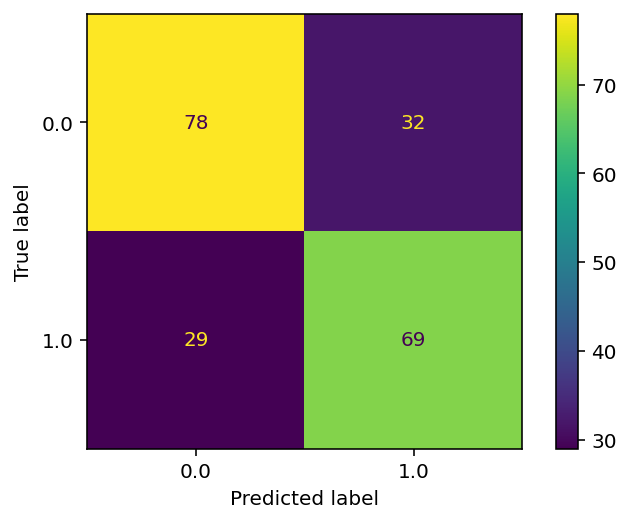

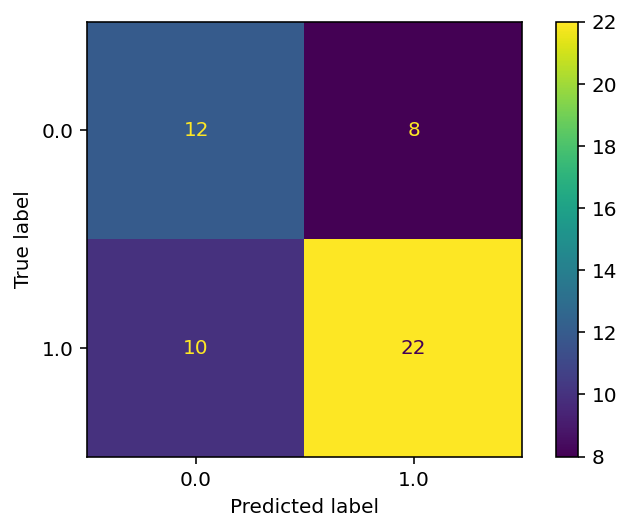

In [ ]:
# Try different number of features to check F1 score and accurary
rf_num8 = RandomForestClassifier(criterion= 'gini', max_depth=10, min_samples_leaf=5, min_samples_split=3, n_estimators=15, random_state=0)  #0.58 0.58
rf_num5 = RandomForestClassifier(criterion= 'entropy', max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=15, random_state=0)  #0.58 0.57
rf_num4 = RandomForestClassifier(criterion= 'gini', max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=5, random_state=0)  #0.56 0.55
rf_num3 = RandomForestClassifier(criterion= 'gini', max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=15, random_state=0)  #0.63 0.63
rf_num2 = RandomForestClassifier(criterion= 'entropy', max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=5, random_state=0)  #0.65 0.64
rf_num1 = RandomForestClassifier(criterion= 'gini', max_depth=3, min_samples_leaf=2, min_samples_split=3, n_estimators=20, random_state=0)  #0.63 0.63

# num=2 has the highest F1 score and accurary
rf = RandomForestClassifier(criterion= 'entropy', max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=5, random_state=0)  #0.65 0.64
rf.fit(x_rf, y)

# Making predictions 
y_train_rf_pred = rf.predict(x_rf) #Training set
y_test_rf_pred = rf.predict(X_test_rf) #Test set

# Calculating F1-scores

# For training: x_rf, y
# For test: X_test_rf, y_test

#Training Report
rf_report_train = classification_report(y, y_train_rf_pred)
print("Training Classification Report: RandomForest Classifier:\n",rf_report_train)

#Getting confusion matrix for Training Data
rf_cm_train = confusion_matrix(y, y_train_rf_pred, labels=rf.classes_)

disp_train_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm_train, display_labels=rf.classes_)
disp_train_rf.plot()

#Testing Report
rf_report_test = classification_report(y_test, y_test_rf_pred)
print("Testing Classification Report: RandomForest Classifier:\n",rf_report_test)

#Getting confusion matrix for Testing Data
rf_cm_test = confusion_matrix(y_test, y_test_rf_pred, labels=rf.classes_)

disp_test_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm_test, display_labels=rf.classes_)
disp_test_rf.plot()

In [ ]:
# Cross validation to check overfiting/underfitting
x_rf_cv = pd.DataFrame(x_rf)
rf_cv = cross_validate(5, x_rf_cv, y, rf)
print("Macro Average F1-score for each fold of Logistic Regression Model: ",rf_cv)
print("Average F1-score: ",np.mean(rf_cv))

Macro Average F1-score for each fold of Logistic Regression Model:  [0.5894192064404831, 0.6755793226381461, 0.5258467023172906, 0.5365853658536586, 0.6759878419452887]
Average F1-score:  0.6006836878389734


In [ ]:
# Best logistic model to save is num=2
model_rf = rf
pickle.dump(model_rf, open('model_rf.sav', 'wb'))

<a name= 'SVM'></a>

####  2.3 SVM

In [ ]:
x_svm, X_test, fs = select_features(x, y, X_test, 6)  # 80% 20%
X_train, x_eval, y_train, y_eval = train_test_split(x_svm, y, test_size=0.25, train_size=0.75, random_state=4, shuffle=True) # 60% 20%

In [ ]:
feature_svm = fs.get_support(indices = True)
feature_names_svm = df_scaled.columns[feature_svm]
print(feature_names_svm)

Index(['ASL', 'NOW', 'NVB', 'NPV', 'NST', 'CDV'], dtype='object')


In [ ]:
# SVM with LinearSVC
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing

# Fitting LinearSVC to training set
clf_li = SVC(kernel='linear')
scaler = preprocessing.StandardScaler()

scaler.fit(X_train)

clf_li.fit(scaler.transform(X_train), np.asarray(y_train))

# Making predictions
y_train_pred = clf_li.predict(X_train) #Training set
y_test_pred = clf_li.predict(scaler.transform(X_test))   #Testing set

Training Classification Report: Logistic Regression :
               precision    recall  f1-score   support

         0.0       0.63      0.96      0.76        83
         1.0       0.90      0.36      0.51        73

    accuracy                           0.68       156
   macro avg       0.76      0.66      0.64       156
weighted avg       0.75      0.68      0.64       156

Testing Classification Report: Logistic Regression:
               precision    recall  f1-score   support

         0.0       0.52      0.80      0.63        20
         1.0       0.81      0.53      0.64        32

    accuracy                           0.63        52
   macro avg       0.66      0.67      0.63        52
weighted avg       0.70      0.63      0.64        52



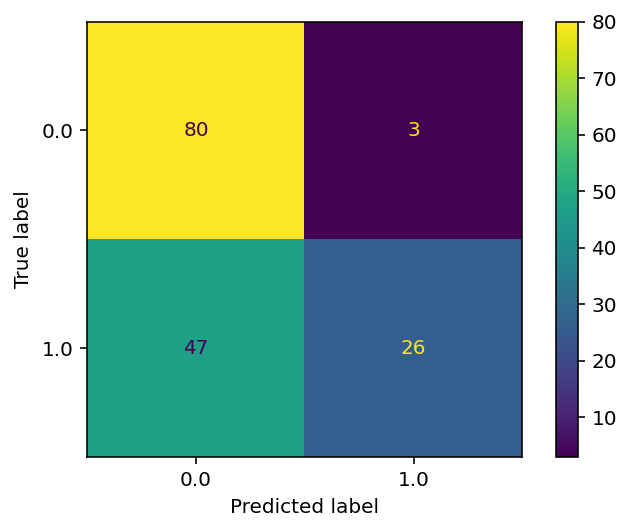

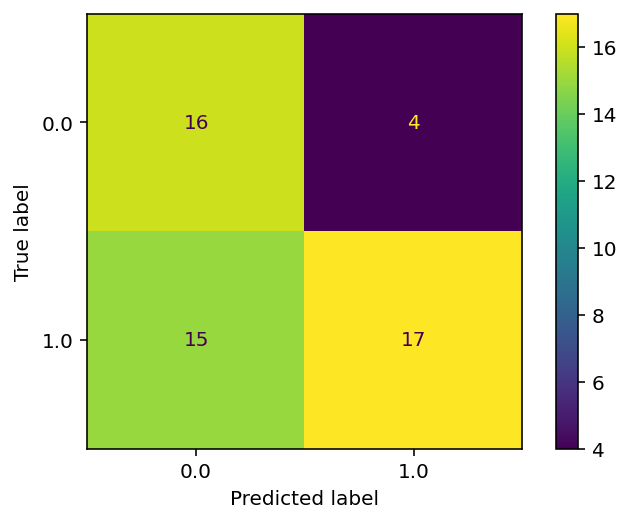

In [ ]:
# Calculating F1-scores & accuracy
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Training Report
report_train = classification_report(y_train, y_train_pred)
print("Training Classification Report: Logistic Regression :\n",report_train)

#Getting confusion matrix for Training Data
cm_train = confusion_matrix(y_train, y_train_pred, labels=clf_li.classes_)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=clf_li.classes_)
disp_train.plot()

#Testing Report
report_test = classification_report(y_test, y_test_pred)
print("Testing Classification Report: Logistic Regression:\n",report_test)

#Getting confusion matrix for Testing Data
cm_test = confusion_matrix(y_test, y_test_pred, labels=clf_li.classes_)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=clf_li.classes_)
disp_test.plot()

In [ ]:
# Cross validation to check overfiting/underfitting
x_cv = pd.DataFrame(x_svm)
cv = cross_validate(5, x_cv, y, clf_li)
print("Macro Average F1-score for each fold of Logistic Regression Model: ",cv)
print("Average F1-score: ",np.mean(cv))

Macro Average F1-score for each fold of Logistic Regression Model:  [0.6298305084745762, 0.5523510971786834, 0.5916666666666667, 0.4576719576719577, 0.5591397849462365]
Average F1-score:  0.5581320029876241


In [ ]:
# Save model
model_svm = x_svm
pickle.dump(model_svm, open('model_svm.sav', 'wb'))